# **DL model_Toxicity prediction of chemicals using smiles dataset**




###**데이터 전처리**

In [ ]:
#Rdkit installation
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [ ]:
#Module import
import numpy
import pandas
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.models import load_model
import os



In [ ]:
#csv 파일을 pandas dataframe으로 읽기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

seed = 7
np.random.seed(seed)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
name=['id',	'SMILES'	,'tox']
data = pd.read_csv('/content/names_smiles.csv',names=name)


data

,id,SMILES,tox
0,NCGC00260230-01,F[P-](F)(F)(F)(F)F.CCCC[N+]1=CC=CC(C)=C1,0
1,NCGC00184995-01,[H][C@@]12CC[C@H](OP(O)(O)=O)[C@@]1(C)CC[C@]3(...,1
2,NCGC00260471-01,[O-][N+](=O)C1=CC=C2NN=CC2=C1,0
3,NCGC00256746-01,CCC1=NC=CN=C1C,0
4,NCGC00183024-01,CCCN(CCC)C(=O)C(CCC(=O)OCCCN1CCN(CCOC(=O)CC2=C...,1
...,...,...,...
7692,NCGC00182048-01,CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2C3=C(SC4=C2C...,0
7693,NCGC00257224-01,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...,0
7694,NCGC00258675-01,CCCCCCC1=CC=C(C=C1)C2=CC=C(C=C2)C#N,0
7695,NCGC00167522-01,OS(O)(=O)=O.OC(CNCCCCCCNCC(O)C1=CC=C(O)C(O)=C1...,0


In [ ]:
data.info

<bound method DataFrame.info of                    id                                             SMILES  tox
0     NCGC00260230-01           F[P-](F)(F)(F)(F)F.CCCC[N+]1=CC=CC(C)=C1    0
1     NCGC00184995-01  [H][C@@]12CC[C@H](OP(O)(O)=O)[C@@]1(C)CC[C@]3(...    1
2     NCGC00260471-01                      [O-][N+](=O)C1=CC=C2NN=CC2=C1    0
3     NCGC00256746-01                                     CCC1=NC=CN=C1C    0
4     NCGC00183024-01  CCCN(CCC)C(=O)C(CCC(=O)OCCCN1CCN(CCOC(=O)CC2=C...    1
...               ...                                                ...  ...
7692  NCGC00182048-01  CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2C3=C(SC4=C2C...    0
7693  NCGC00257224-01  C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...    0
7694  NCGC00258675-01                CCCCCCC1=CC=C(C=C1)C2=CC=C(C=C2)C#N    0
7695  NCGC00167522-01  OS(O)(=O)=O.OC(CNCCCCCCNCC(O)C1=CC=C(O)C(O)=C1...    0
7696  NCGC00183830-01  COC(=O)C1=C(C)NC(COC(N)=O)=C(C1C2=C(Cl)C(Cl)=C...    0

[7697 rows x 3 columns]>

In [ ]:
# tox(독성:1 비독성:0)행의 value를 count
print(data['tox'].value_counts())

0    6760
1     937
Name: tox, dtype: int64


In [ ]:
data.value_counts()

In [ ]:
mols = []
fps = []

for index, row in data.iterrows():
        try :
            mol = Chem.MolFromSmiles(row['SMILES']) #smiles 형태의 데이터를 읽어들임
        except :
            continue

        try :
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2) #radius=2의 morgan finger print를 얻음
        except :
            continue

        mols.append(mol)
        fps.append(fp) #리스트에 저장

In [ ]:
np_fps = []
for fp in fps:
        arr = numpy.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        np_fps.append(arr) #morgan fingerprint를 numpy.array 형태로 바꿔줌

In [ ]:
np_fps

In [ ]:
len(np_fps)

7695

In [ ]:
data.value_counts

<bound method DataFrame.value_counts of                    id                                             SMILES  tox
0     NCGC00260230-01           F[P-](F)(F)(F)(F)F.CCCC[N+]1=CC=CC(C)=C1    0
1     NCGC00184995-01  [H][C@@]12CC[C@H](OP(O)(O)=O)[C@@]1(C)CC[C@]3(...    1
2     NCGC00260471-01                      [O-][N+](=O)C1=CC=C2NN=CC2=C1    0
3     NCGC00256746-01                                     CCC1=NC=CN=C1C    0
4     NCGC00183024-01  CCCN(CCC)C(=O)C(CCC(=O)OCCCN1CCN(CCOC(=O)CC2=C...    1
...               ...                                                ...  ...
7692  NCGC00182048-01  CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2C3=C(SC4=C2C...    0
7693  NCGC00257224-01  C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...    0
7694  NCGC00258675-01                CCCCCCC1=CC=C(C=C1)C2=CC=C(C=C2)C#N    0
7695  NCGC00167522-01  OS(O)(=O)=O.OC(CNCCCCCCNCC(O)C1=CC=C(O)C(O)=C1...    0
7696  NCGC00183830-01  COC(=O)C1=C(C)NC(COC(N)=O)=C(C1C2=C(Cl)C(Cl)=C...    0

[7697 rows x 3 columns]

In [ ]:
m =np_fps[0]
np_fps+m


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [ ]:
data=data.drop(index=7696)
data=data.drop(index=7695)
data['SMILES2']=np_fps

In [ ]:
data

,id,SMILES,tox,SMILES2
0,NCGC00260230-01,F[P-](F)(F)(F)(F)F.CCCC[N+]1=CC=CC(C)=C1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,NCGC00184995-01,[H][C@@]12CC[C@H](OP(O)(O)=O)[C@@]1(C)CC[C@]3(...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,NCGC00260471-01,[O-][N+](=O)C1=CC=C2NN=CC2=C1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,NCGC00256746-01,CCC1=NC=CN=C1C,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,NCGC00183024-01,CCCN(CCC)C(=O)C(CCC(=O)OCCCN1CCN(CCOC(=O)CC2=C...,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
7690,NCGC00260116-01,CC(=C)C(=O)OCCC[Si](Cl)(Cl)Cl,0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
7691,NCGC00260383-01,[H]C(=O)C(\C)=C(/[H])C,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7692,NCGC00182048-01,CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2C3=C(SC4=C2C...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7693,NCGC00257224-01,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
y = data['tox']
x = data.drop(['tox'],axis=1)

In [ ]:
names=[]
for i in range (0,2048) :
    names=names+[i]
names[2047]

2047

In [ ]:
pivot=[[0]*7695 for i in range (2048)]
for i in range(1,2048):
    for j in range(1,7695):
        pivot[i][j]=data['SMILES2'][j][i]
pivot

In [ ]:
for i in range(2048):
  data[names[i]]=pivot[i]

In [ ]:
data

,id,SMILES,tox,SMILES2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,NCGC00260230-01,F[P-](F)(F)(F)(F)F.CCCC[N+]1=CC=CC(C)=C1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NCGC00184995-01,[H][C@@]12CC[C@H](OP(O)(O)=O)[C@@]1(C)CC[C@]3(...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCGC00260471-01,[O-][N+](=O)C1=CC=C2NN=CC2=C1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCGC00256746-01,CCC1=NC=CN=C1C,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NCGC00183024-01,CCCN(CCC)C(=O)C(CCC(=O)OCCCN1CCN(CCOC(=O)CC2=C...,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7690,NCGC00260116-01,CC(=C)C(=O)OCCC[Si](Cl)(Cl)Cl,0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7691,NCGC00260383-01,[H]C(=O)C(\C)=C(/[H])C,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7692,NCGC00182048-01,CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2C3=C(SC4=C2C...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7693,NCGC00257224-01,C[Si

In [ ]:
have_tox=data[data["tox"]==1] #tox를 가진 인덱스만 골라냄

In [ ]:
have_tox

In [ ]:
b=have_tox['tox']
a=have_tox.drop(['tox'],axis=1) #tox 행 제거

In [ ]:
data['tox']=y
y=data['tox']
data=data.drop(['tox'],axis=1)
x=data.drop(['SMILES2'],axis=1)
x=x.drop(['id'],axis=1)
x=x.drop(['SMILES'],axis=1)
x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7690,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7691,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7692,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7693,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y

0       0
1       1
2       0
3       0
4       1
       ..
7690    0
7691    0
7692    0
7693    0
7694    0
Name: tox, Length: 7695, dtype: int64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 156)
stratify=y

### **모델 학습**

***결정트리***

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classification
dt = DecisionTreeClassifier()

dt.fit(x_train, y_train)
dt_prediction = dt.predict(x_test)

***DNN***

In [ ]:
#DNN 모델
def create_deep_learning_model():
    model = Sequential()
    model.add(Dense(2048, input_dim=2048, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
#모델 컴파일
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# 모델 학습
model= create_deep_learning_model()
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=20,
                    batch_size=7,verbose=2) # 0 = silent, 1 = progress bar, 2 = one line per epoch.

Epoch 1/20
880/880 - 58s - loss: 0.4199 - accuracy: 0.8782 - val_loss: 0.4053 - val_accuracy: 0.8765
Epoch 2/20
880/880 - 41s - loss: 0.3462 - accuracy: 0.8785 - val_loss: 0.4375 - val_accuracy: 0.8765
Epoch 3/20
880/880 - 41s - loss: 0.2929 - accuracy: 0.8775 - val_loss: 0.5005 - val_accuracy: 0.8765
Epoch 4/20
880/880 - 41s - loss: 0.2253 - accuracy: 0.9009 - val_loss: 0.6363 - val_accuracy: 0.8369
Epoch 5/20
880/880 - 40s - loss: 0.1724 - accuracy: 0.9282 - val_loss: 0.9976 - val_accuracy: 0.8291
Epoch 6/20
880/880 - 41s - loss: 0.1343 - accuracy: 0.9417 - val_loss: 1.0030 - val_accuracy: 0.8109
Epoch 7/20
880/880 - 44s - loss: 0.1124 - accuracy: 0.9505 - val_loss: 1.2885 - val_accuracy: 0.8168
Epoch 8/20
880/880 - 41s - loss: 0.0982 - accuracy: 0.9531 - val_loss: 1.4824 - val_accuracy: 0.8233
Epoch 9/20
880/880 - 41s - loss: 0.0904 - accuracy: 0.9563 - val_loss: 1.4210 - val_accuracy: 0.8343
Epoch 10/20
880/880 - 41s - loss: 0.0832 - accuracy: 0.9586 - val_loss: 1.7626 - val_accura

In [ ]:
model.save('predict_toxicity')

INFO:tensorflow:Assets written to: predict_toxicity/assets


***선형회귀***

In [ ]:
#선형 회귀
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
lr_reg = LinearRegression()
lr_reg.fit(x_train,y_train)
pred = lr_reg.predict(x_test)

### **모델 예측 및 평가**

 ***결정트리***

In [ ]:
from sklearn.metrics import accuracy_score

# 정확도 출력
accuracy_score(y_test, dt_prediction)

0.7946718648473035

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# 결정트리 시각화
export_graphviz(dt, out_file='tree.dot',
                class_names=["not tox", "tox"],
                feature_names=x_train.columns,
                impurity=True, # gini 계수 출력
                filled=True) # class별 color 채우기

with open('tree.dot') as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

print('오차 행렬\n', confusion_matrix(y_test, dt_prediction))
print('\n평가 지표\n', classification_report(y_test, dt_prediction))

오차 행렬
 [[1205  144]
 [ 172   18]]

평가 지표
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      1349
           1       0.11      0.09      0.10       190

    accuracy                           0.79      1539
   macro avg       0.49      0.49      0.49      1539
weighted avg       0.78      0.79      0.79      1539



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

print('오차 행렬\n', confusion_matrix(y_test, dt_prediction))
print('\n평가 지표\n', classification_report(y_test, dt_prediction))

오차 행렬
 [[1205  144]
 [ 172   18]]

평가 지표
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      1349
           1       0.11      0.09      0.10       190

    accuracy                           0.79      1539
   macro avg       0.49      0.49      0.49      1539
weighted avg       0.78      0.79      0.79      1539



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 트리 개수 최대 100개
rf = RandomForestClassifier(n_estimators=100,max_features=5,random_state=0)
rf.fit(x_train , y_train)
rf_prediction = rf.predict(x_test)

print('오차 행렬\n', confusion_matrix(y_test, rf_prediction))
print('\n평가 지표\n', classification_report(y_test, rf_prediction))

오차 행렬
 [[1295   54]
 [ 183    7]]

평가 지표
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1349
           1       0.11      0.04      0.06       190

    accuracy                           0.85      1539
   macro avg       0.50      0.50      0.49      1539
weighted avg       0.78      0.85      0.81      1539



***DNN***

In [ ]:
# DNN 학습 결과 그래프 출력
def modelplot(history, data, val_data):
  plt.plot(history.history[data])
  plt.plot(history.history[val_data])
  plt.title('Model'+ data)
  plt.ylabel(data)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'])
  plt.show()

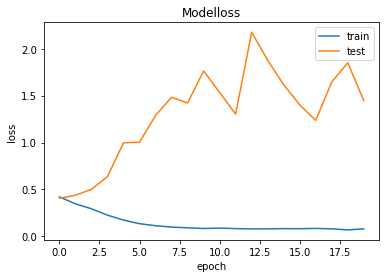

In [ ]:
modelplot(history, 'loss', 'val_loss')

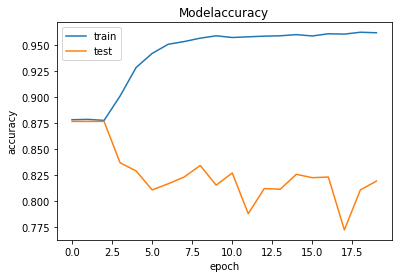

In [ ]:
modelplot(history, 'accuracy', 'val_accuracy')

***선형 회귀***

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def model_evaluate(y, pred):
    MSE_val = mean_squared_error(y, pred)
    RMSE_val = np.sqrt(MSE_val)
    MAE_val = mean_absolute_error(y, pred)

    print('MSE: {0:.3f}, RMSE: {1:.3F}, MAE:{2:.3F}'.format(MSE_val,RMSE_val, MAE_val))

model_evaluate(y_test,pred)

MSE: 0.200, RMSE: 0.447, MAE:0.200


### **모델 테스트**

In [ ]:
# samples 변수에 smiles 입력하기
samples = ['CNC1=C2N=CN([C@@H]3O[C@H](CO)C(O)[C@H]3O)C2=NC=N1','OC1=CC(\C=C\C2=CC=C(O)C(O)=C2)=CC(O)=C1','Cl.CN1CCC2=CC(NC(=O)NC3=CC=CN=C3)=CC=C12','[Cl-].COC1=CC=C2C3=CC=C4C=C5OCOC5=CC4=C3[N+](C)=CC2=C1OC']
tx =[0,0,1,0]

col_name = ['SMILES3', 'tox']
df = pd.DataFrame()
df['SMILES3']=samples
df['tox']=tx

df

,SMILES3,tox
0,CNC1=C2N=CN([C@@H]3O[C@H](CO)C(O)[C@H]3O)C2=NC=N1,0
1,OC1=CC(\C=C\C2=CC=C(O)C(O)=C2)=CC(O)=C1,0
2,Cl.CN1CCC2=CC(NC(=O)NC3=CC=CN=C3)=CC=C12,1
3,[Cl-].COC1=CC=C2C3=CC=C4C=C5OCOC5=CC4=C3[N+](C...,0


In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole


mol_list = [Chem.MolFromSmiles(smiles) for smiles in samples]
img = Draw.MolsToGridImage(mol_list)
img

In [ ]:
molss = []
fpss = []

for index, row in df.iterrows():
        try :
            moll = Chem.MolFromSmiles(row['SMILES3']) #smiles 형태의 데이터를 읽어들임
        except :
            continue

        try :
            fpp = AllChem.GetMorganFingerprintAsBitVect(moll, 2) #radius=2의 morgan finger print를 얻음
        except :
            continue

        molss.append(moll)
        fpss.append(fpp) #리스트에 저장

In [ ]:
np_fps_2 = []
for fpp in fpss:
        arr_2 = numpy.zeros((1,))
        DataStructs.ConvertToNumpyArray(fpp, arr_2)
        np_fps_2.append(arr_2) #morgan fingerprint를 numpy.array 형태로 바꿔줌

In [ ]:
len(np_fps_2)

4

In [ ]:
np_fps_2

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [ ]:
m =np_fps_2[0]
np_fps_2+m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
df['SMILES3']=np_fps_2

In [ ]:
names_=[]
for i in range (0,2048) :
    names_=names_+[i]
names_[2047]

2047

In [ ]:
pivot_2=[[0]*4 for i in range (2048)]
for i in range(1,2048):
    for j in range(1,4):
        pivot_2[i][j]=df['SMILES3'][j][i]
pivot_2

In [ ]:
for i in range(2048):
  df[names_[i]]=pivot_2[i]

In [ ]:
df

In [ ]:
df=df.drop('SMILES3',axis=1)

In [ ]:
toxx =df[ 'tox' ]
df=df.drop('tox', axis=1)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from keras.models import load_model
model_1 = load_model('predict_toxicity')


In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 6,397,129
Trainable params: 6,397,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#DNN 모델 테스트
print('The Answer is ', model.predict_classes(df))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The Answer is  [[0]
 [0]
 [0]
 [0]]


In [ ]:
toxx


0    0
1    0
2    1
3    0
Name: tox, dtype: int64

In [ ]:
#선형회귀 모델 테스트
print('The Answer is ', lr_reg.predict_classes(df))

The Answer is  [[0]
 [0]
 [0]
 [0]]


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
